In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pymongo import MongoClient

sys.path.append('..')

MONGODB_URI = os.environ.get('MONGODB_URI')
database = ''.join(MONGODB_URI.rsplit('/')[-1:])
conn = MongoClient(host=MONGODB_URI)
mongodb = conn[database]


In [3]:
from carrega_modelo_final_rc import ModelContaminado

model = ModelContaminado()

In [4]:
from atualiza_mongo_rc import ComunicaReeeferContaminado

comunicador = ComunicaReeeferContaminado(model, mongodb)
def print_one():
    registro = next(comunicador.cursor)
    _id = registro['_id']
    predictions_reefer = registro['metadata']['predictions'][0]['reefer'][0]
    print(_id, predictions_reefer)
    comunicador.get_pil_image(_id)
    print(model.predict(comunicador.pil_image))


INFO:root:Consulta ao banco efetuada.


In [6]:
print_one()
comunicador.pil_image

StopIteration: 

In [ ]:
print_one()
comunicador.pil_image

In [16]:
import io
from PIL import Image, ImageDraw
from gridfs import GridFS

fs = GridFS(mongodb)

def pil_image_bbox(_id, coords):
    pil_image = Image.open(io.BytesIO(fs.get(_id).read()))
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle((coords[0] -2, coords[1] - 2, coords[2] + 2, coords[3] + 2),
                    outline='#2288EE', width=4)
    return pil_image

def print_one_2(cursor):
    registro = next(cursor)
    _id = registro['_id']
    reefer = registro['metadata']['predictions'][0]['reefer']
    print(_id, reefer)
    pil_image = pil_image_bbox(_id, reefer[0]['reefer_bbox'])
    return pil_image

FILTRO_CONTAMINADO = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.reefer.reefer_bbox': {'$exists':True},
          'metadata.predictions.reefer.reefer_class': 2,            
          'metadata.predictions.reefer.reefer_contaminado': True}

FILTRO_N = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.reefer.reefer_bbox': {'$exists': True},
          'metadata.predictions.reefer.reefer_class': 2,
          'metadata.predictions.reefer.reefer_contaminado': False}

cursor_contaminado = mongodb['fs.files'].find(FILTRO_CONTAMINADO, {'metadata.predictions': 1})
cursor_nao = mongodb['fs.files'].find(FILTRO_N, {'metadata.predictions': 1})

603cefe9beb63828c35ed3a8 [{'reefer_bbox': [166.6611785888672, 18.8074951171875, 236.47132873535156, 627.6705322265625], 'reefer_class': 0, 'reefer_score': 0.9947565793991089, 'reefer_contaminado': True}]


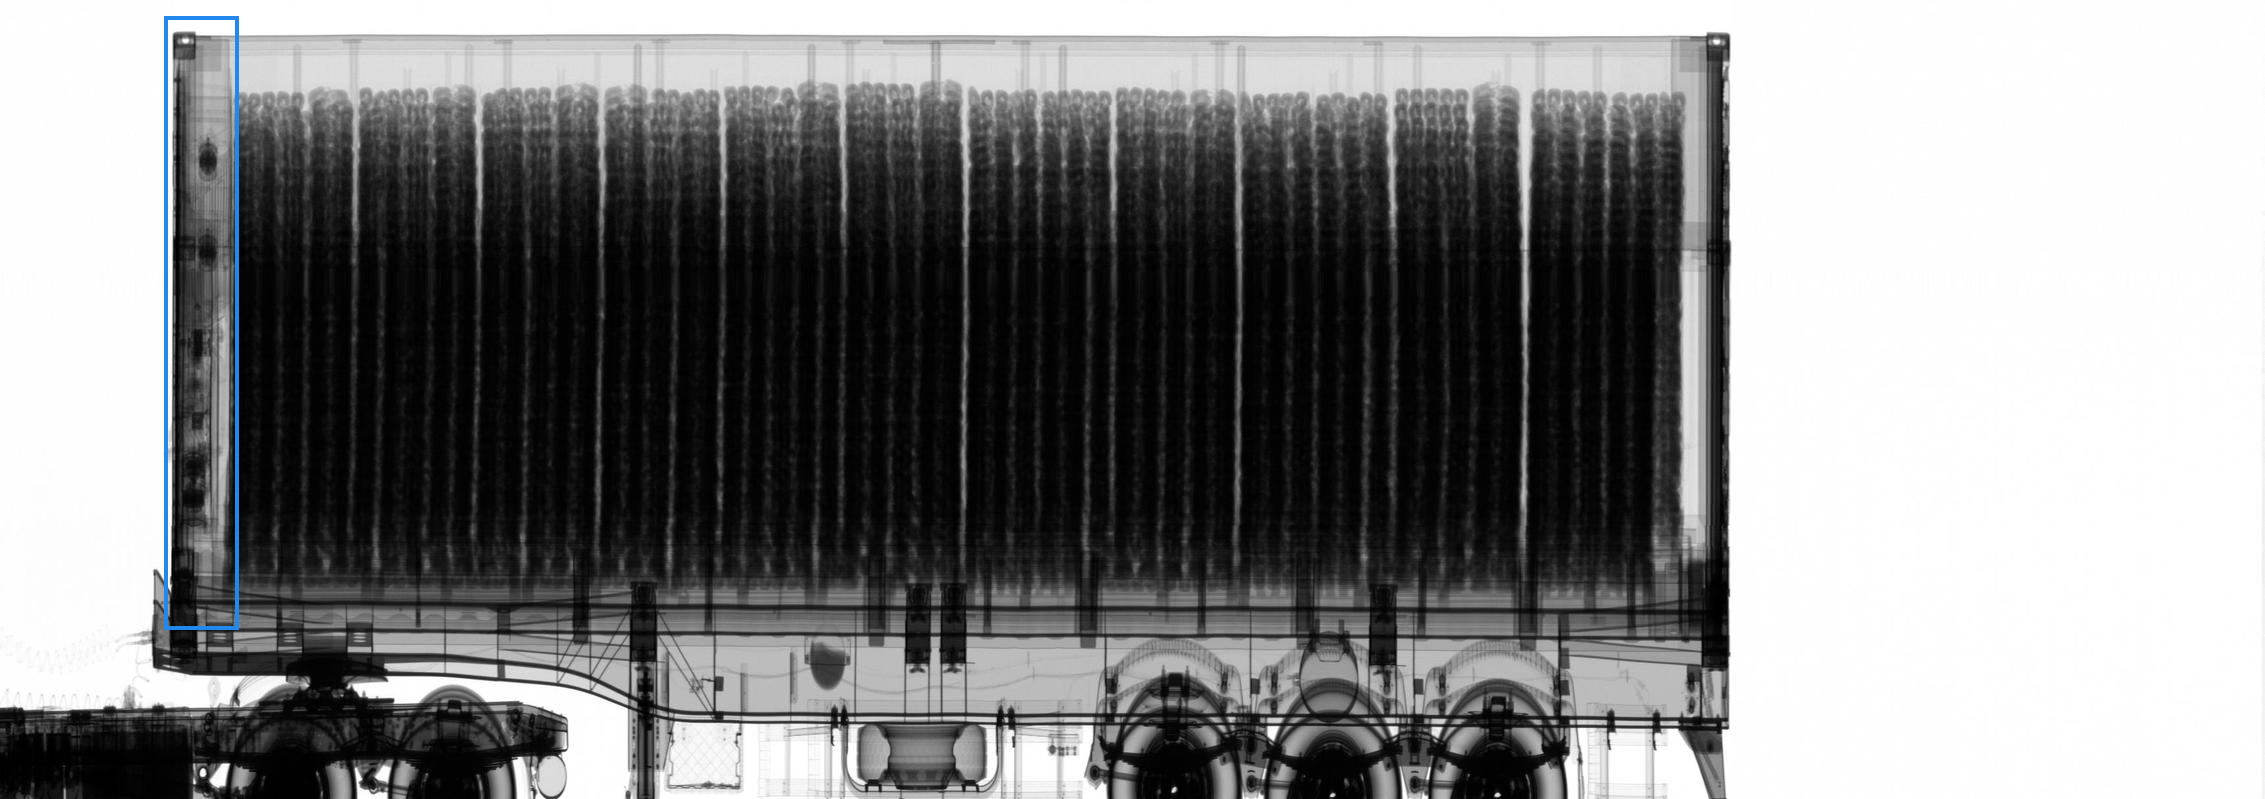

In [14]:
print_one_2(cursor_contaminado)

In [17]:
for registro in cursor_contaminado:
    pil_image = comunicador.get_pil_image(registro['_id'])
    pil_image.save(f"{str(registro['_id'])}.jpg")

603cee3dbeb63828c35eaf1a [{'reefer_bbox': [129.83766174316406, 20.43030548095703, 229.66961669921875, 637.4176635742188], 'reefer_class': 0, 'reefer_score': 0.9828559756278992, 'reefer_contaminado': False}]


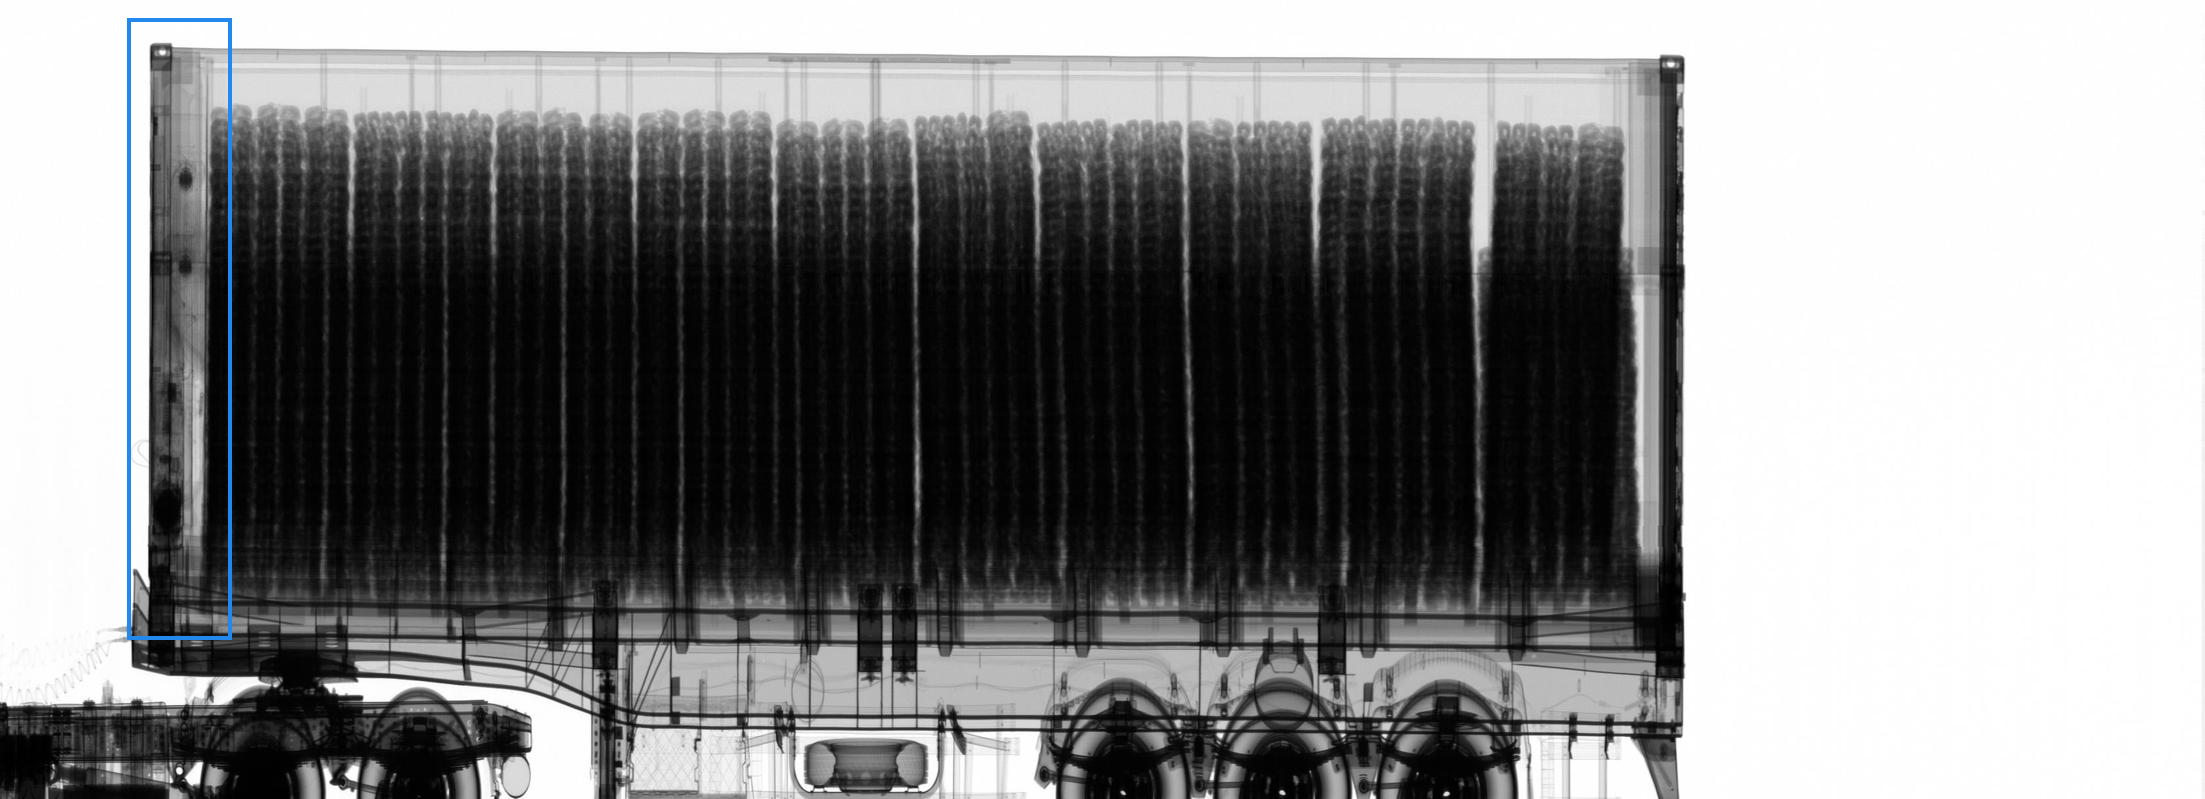

In [24]:
print_one_2(cursor_nao)

In [18]:
for registro in cursor_nao:
    pil_image = comunicador.get_pil_image(registro['_id'])
    pil_image.save(f"{str(registro['_id'])}.jpg")